# A Genomics Example Using the pyspark Library

A standard problem in metagenomics is to determine which species are present in a biological sample. This problem has many applications, from testing for specific viral and bacterial infections, to complete analysis of a human microbiome.  

In this example notebook, we make use of the pyspark library to illustrate some techniques used in species classification. The basic idea is to make use of k-mers, a biological analog of n-grams, to compute the "distance" from one genetic sample to another. With enough distance calculations, we can predict with reasonable accuracy that two samples are the same if the distance between them is “small”.

We note that this is a python3 notebook. At the moment, python3 is required to use the pyspark library.

First we import the third-party libraries we will need. Beyond some standard library imports, we also import matplotlib for plotting, numpy and scipy for numerical calculations, urllib for downloading the datasets, and pyspark for parallel computation. 

In [1]:
import string, os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image, display, Math, Latex, SVG, HTML
import numpy as np
from scipy.cluster.hierarchy import linkage,dendrogram
from scipy.spatial.distance import pdist
# from urllib2 import urlopen
from urllib.request import urlopen
import pyspark
sc = pyspark.SparkContext('local[*]')

In this notebook, we only concern ourselves with 5 different pathogens. We will compute pairwise k-mer distances to each of the following:

## Pathogens ##

- Campylobacter jejuni - causes infectious diarrhea
- Helicobacter pylori - ulcers and stomach cancer
- Listeria monocytogenes - infections of the central nervous system
- Salmonella enterica - diarrhea, fever, vomiting
- Ebolavirus - hemorrhagic fever

We define a tuple of the pathogens we will analyze in this notebook. The id's refer to the NCBI database (http://www.ncbi.nlm.nih.gov/), which we use to download the files in parallel (using spark) and create a spark RDD.

In [2]:
# Toy pathogen dataset of names and IDs

bacteria = (\
("Campylobacter_jejuni_4031_uid222817","NC_022529.fna"),\
("Campylobacter_jejuni_RM1221_uid57899","NC_003912.fna"),\
("Helicobacter_pylori_2017_uid161151","NC_017374.fna"),\
("Helicobacter_pylori_Puno135_uid161157","NC_017379.fna"),\
("Listeria_monocytogenes_ATCC_19117_uid175109","NC_018584.fna"),\
("Listeria_monocytogenes_J0161_uid54459","NC_017545.fna"),\
("Listeria_monocytogenes_SLCC2376_uid175111","NC_018590.fna"),\
("Salmonella_enterica_serovar_Paratyphi_C_RKS4594_uid59063","NC_012125.fna"),\
("Salmonella_enterica_serovar_Typhimurium_14028S_uid86059","NC_016856.fna"))
viruses = (\
("Bundibugyo_ebolavirus_uid51245","NC_014373.fna"),\
("Sudan_ebolavirus_uid15012","NC_006432.fna"),\
("Tai_Forest_ebolavirus_uid51257","NC_014372.fna"))

In [3]:
# Where to pull genomes from NCBI

baseURL = "ftp://ftp.ncbi.nih.gov/genomes"
bacteriaURL = baseURL+"/archive/old_refseq/Bacteria"
virusURL = baseURL+"/Viruses"

bacteriaURLs = [('_'.join(name.split('_')[:-1]), bacteriaURL+"/"+name+"/"+nc) for name, nc in bacteria]
virusURLs = [('_'.join(name.split('_')[:-1]), virusURL+"/"+name+"/"+nc) for name, nc in viruses]

genomeURLs = bacteriaURLs+virusURLs

def getSequence(url):
    FILE = urlopen(url)
    tmp = FILE.readline()
    return ''.join(map(lambda x: x.decode().rstrip('\n'), FILE.readlines()))

# Download genomes in parallel and create PySpark RDD
genomes = sc.parallelize(genomeURLs).mapValues(getSequence)

# Print out sample of data
data = genomes.map(lambda x: (x[0],len(x[1]),x[1][:20])).collect() # collect partial sequences

print("%50s %8s %20s"%("Pathogen","Bases","Sequence"))
for name, lenSeq, seq in data:
    print("%50s %8i %20s"%(name, lenSeq, seq))

                                          Pathogen    Bases             Sequence
                         Campylobacter_jejuni_4031  1669329 ATGAATCCAAGCCAAATACT
                       Campylobacter_jejuni_RM1221  1777831 ATGAATCCAAGCCAAATACT
                          Helicobacter_pylori_2017  1548238 GTGATTAGTGATTAGTGATT
                       Helicobacter_pylori_Puno135  1646139 TAAAACACCCTCAATTCAAG
                 Listeria_monocytogenes_ATCC_19117  2951805 TAATTAAATCTAACAATTTC
                      Listeria_monocytogenes_J0161  3000464 TAATTAAATCTAACAATTTC
                   Listeria_monocytogenes_SLCC2376  2840185 TAATTAAATCTAACAATTTC
   Salmonella_enterica_serovar_Paratyphi_C_RKS4594  4833080 AGAGATTACGTCTGGTTGCA
    Salmonella_enterica_serovar_Typhimurium_14028S  4870265 AGAGATTACGTCTGGTTGCA
                             Bundibugyo_ebolavirus    18940 CGGACACACAAAAAGAATGA
                                  Sudan_ebolavirus    18875 CGGACACACAAAAAGAAAGA
                            

## Comparing Genomes ##
Comparing the genomes of the pathogens is not trivial. Not only does each genome have a different length, but also unique mutations between variants of the same species. One way to quantify these unique features without worrying about the biology is with **n-grams**: overlapping subsequences of N items. While n-grams were made for words, **k-mers** is the biological equivalent for nucleotides (AGCT). Assuming we had the following DNA sequence
```
ACCTGGTATA
```
The first two 4-mers (i.e., k=4) would be `ACCT` and `CCTG`.
```
ACCTGGTATA
ACCT
 CCTG
```
Couting the occurance of k-mers allows genomic sequences to be compared in vector-space.

In [4]:
def countKmers(seq):
    # Function for counting k-mers using a hashing function.
    # Modify k and arraySize for overal uniqueness
    k = 7 # k-mer size
    arraySize = 10000 # count array size
    countArray = np.zeros(arraySize, dtype=np.uint32) # count array
    for i in range(len(seq)-k):
        kmer = seq[i:i+k] # pull kmer from sequence
        hashValue = hash(kmer)%arraySize # calculate hash value
        countArray[hashValue] += 1 # add count
    return countArray

# Count kmers in parallel
genomeKmerFreqs = genomes.mapValues(countKmers).collect()

A metric for quantifying set similarity.



<IPython.core.display.Math object>


J(C.jejuni, H.pylori) = 0.9923


Distance metric based on correlation coefficient.



<IPython.core.display.Math object>


corrD(C.jejuni, H.pylori) = 0.1596


Angular distance between two vectors.


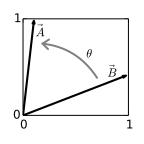

<IPython.core.display.Math object>


cosD(C.jejuni, H.pylori) = 0.1133


Distance between two vectors.



<IPython.core.display.Math object>


euclidean(C.jejuni, H.pylori) = 15039.5047
euclidean(C.jejuni, H.pylori) = 0.4760 using unit vectors


In [6]:
# Calculate Distance

# Pull out the frequency counts for
# Campylobacter_jejuni_4031 and Helicobacter_pylori_2017
cJejuni = genomeKmerFreqs[0][1]
hPylori = genomeKmerFreqs[2][1]

from scipy.spatial.distance import jaccard, correlation, cosine, euclidean

def pp(text):
    display(HTML("<h2>%s</h2><hr>"%(text)))

pp("Jaccard Distance")
print("A metric for quantifying set similarity.\n")
display(Math(r'JD(A,B)=1-\frac{|A \cap B|}{|A \cup B|}, \quad 0 \le JD(A,B) \le 1'))
print("\nJ(C.jejuni, H.pylori) = %.4f"%(jaccard(cJejuni, hPylori)))

pp("Correlation Distance")
print("Distance metric based on correlation coefficient.\n")
display(Math(r'corrD(A,B)= 1 - \frac{(u - \bar{u}) \dot (v - \bar{v})}{{\|(u - \bar{u})\|}_2\
{\|(v - \bar{v})\|}_2}, \quad 0 \le corrD(A,B) \le 2'))
print("\ncorrD(C.jejuni, H.pylori) = %.4f"%(correlation(cJejuni, hPylori)))

pp("Cosine Distance")
print("Angular distance between two vectors.")
display(SVG('cosine_distance.svg'))
display(Math(r'cosD(A,B)=1-cos(\theta), \quad 0 \le cosD(A,B) \le 1'))
print("\ncosD(C.jejuni, H.pylori) = %.4f"%(cosine(cJejuni, hPylori)))

pp("Euclidean Distance")
print("Distance between two vectors.\n")
display(Math(r'euclidean(A,B)=\|A-B\|_2, \quad 0 \le cosD(A,B) < \infty'))
print("\neuclidean(C.jejuni, H.pylori) = %.4f"%(euclidean(cJejuni, hPylori)))
print('euclidean(C.jejuni, H.pylori) = %.4f using unit vectors'%\
    (euclidean(cJejuni/np.linalg.norm(cJejuni),\
    hPylori/np.linalg.norm(hPylori))))

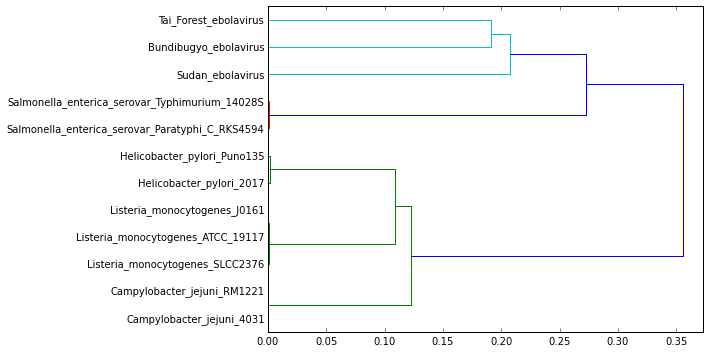

In [13]:
# Use scipy to calculate distance and plot relationships as a tree

names = map(lambda x: x[0], genomeKmerFreqs) # Pull out the names for labels
freqs = map(lambda x: x[1], genomeKmerFreqs) # Pull out the frequencies

Z = linkage(list(freqs), method='complete', metric='cosine')
plt.figure(figsize=(10,5))
dendrogram(Z, labels=list(names), orientation='left')
plt.tight_layout(rect=[0,0,1,1])
plt.show()